## Lesson 02: Deployment

Design your own machine learning project!

Create your own dataset, train a model using your data and deploy an application on the web using Hugging Face Spaces

In [25]:
import os
from fastbook import *
from fastai.vision.widgets import *

### Gathering Data

For many projects you may be able to find all the data you need online. The project for this notebook is a _bear detector_. It will discriminate between three types of bear: `grizzly`, `black`, `teddy bears`. This project will use the Bing Search Image API for retreiving the images

In [3]:
api_key = os.environ.get('AZURE_BING_SEARCH_API_KEY')

In [4]:
results = search_images_bing(api_key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

150

In [5]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

Path('images/grizzly.jpg')

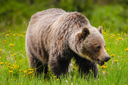

In [6]:
im = Image.open(dest)
im.to_thumb(128,128)

In [7]:
bear_types = 'grizzly', 'black', 'teddy'
path = Path('bears')

In [8]:
if not path.exists():
    path.mkdir()
    for bear_type in bear_types:
        dest = (path/bear_type)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(api_key, f'{bear_type} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [9]:
fns = get_image_files(path)
fns

(#422) [Path('bears/grizzly/34efdee5-abb5-48c2-a94a-70e9ce3d931f.jpg'),Path('bears/grizzly/e31847f7-12a3-4853-be46-9305b58d968c.jpg'),Path('bears/grizzly/e36b17de-0f1b-412c-8a0c-dd817bb4a6f4.jpg'),Path('bears/grizzly/be34bcec-f0d1-4dd7-aab7-fae677dbd972.jpg'),Path('bears/grizzly/65f5e4c6-86ad-49df-bddc-498371517233.jpg'),Path('bears/grizzly/c0a6dfe0-6166-4805-b263-5fde962f6d8a.jpg'),Path('bears/grizzly/64ab7b1c-c5e8-4707-bb1b-ba661eabca37.jpg'),Path('bears/grizzly/828226fd-a735-4357-931e-1b334aa9131e.jpg'),Path('bears/grizzly/26ad26ec-f249-47bd-9f1c-82a4ea12a0b8.jpg'),Path('bears/grizzly/4f902dfe-5916-4619-ac7e-414adca86fcf.jpg')...]

In [10]:
failed = verify_images(fns)
failed

(#0) []

In [11]:
failed.map(Path.unlink)

(#0) []

### From Data to DataLoaders

`DataLoaders` is a thin class that stores whatever `DataLoader` objects you pass to it, making them available as `train` and `valid`. It is a very simple, yet very important, class in the fastai library; it provides the data for your model

In [12]:
bears = DataBlock(
    # inputs are images, outputs are categories
    blocks=(ImageBlock, CategoryBlock),
    # given a path, return a list of all images in that path (recursively)
    get_items=get_image_files,
    # split the dataset into training and validation sets
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    # label y-axis by folder program is inside
    get_y=parent_label,
    # resize all iamges to 128x128 for the purposes of even evaluation and batch size
    item_tfms=Resize(128)
)

In [13]:
dls = bears.dataloaders(path)

We can preview a batch in the dataloaders with the `show_batch()` function

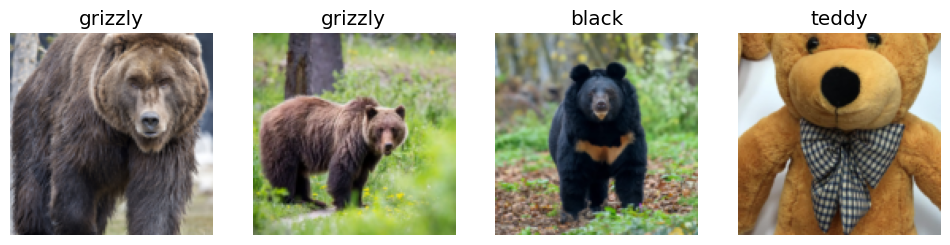

In [14]:
dls.valid.show_batch(max_n=4, nrows=1)

Above, we can see that the images are cropped due to the resizing done in the `DataLoader` constructor. This is not a good practice because it can lead to a negative effect on the ability for the model the perform recognition. In practice, what is normally done is to randomly select part of the image, and crop to just that part. On each epoch randomly select a different part of each image, meaning the model can learn to focus on, and recognize, different features in our images. This reflects the real world more closely where different photos of the same thing may be framed in slightly different ways

`unique=True` is used to have the same image repeated with different versions
of the RandomResizedCrop transformation. This is called _data augmentation_

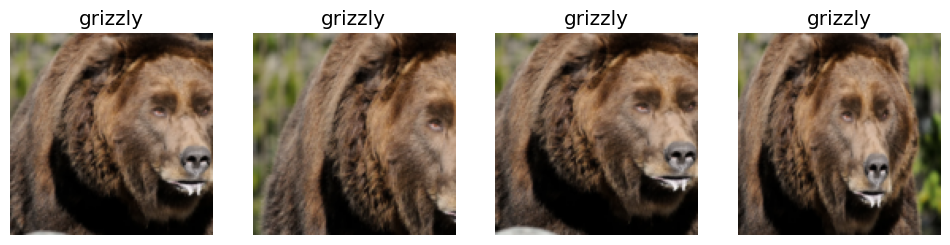

In [15]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation

_Data augmentation_ refers to creating random variations of our input data, such that they appear different, but do not actually change the meaning of the data. Common techniques for images are rotation, flipping, perspective wraping, brightness changes and contrast changes

/Users/charlie/anaconda3/lib/python3.11/site-packages/torch/_tensor.py:1386: UserWarning: The operator 'aten::_linalg_solve_ex.result' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_5ae0635zuj/croot/pytorch-select_1700511177724/work/aten/src/ATen/mps/MPSFallback.mm:13.)
  ret = func(*args, **kwargs)


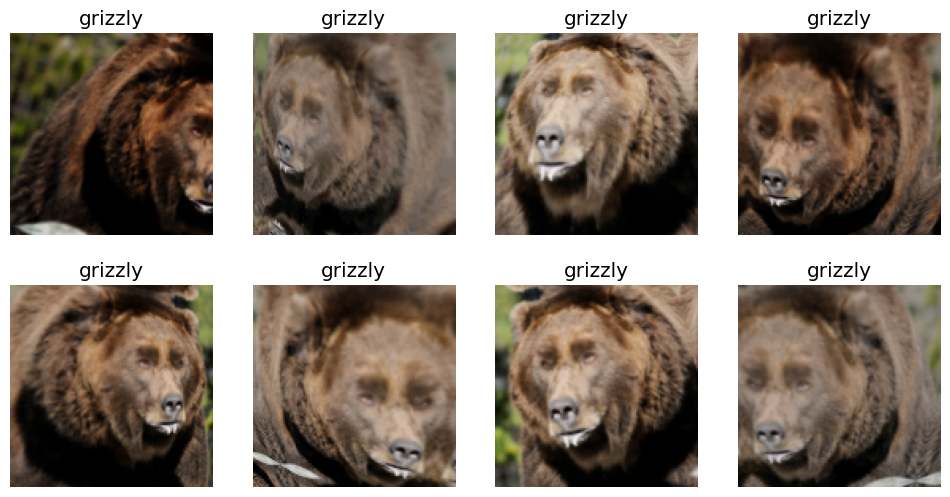

In [16]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

### Train Your Model, Using It to Clean Your Data

Time to train the bear classifier

Since there is a small amount of training data (~150 images), a `RandomResizedCrop` will be used with an image size of `224px`, which is fairly standard for image classification, and default `aug_transforms`

In [18]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)
dls = bears.dataloaders(path)

A `Learner` can now be created and fine-tuned in the usual way

In [19]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.331934,0.249033,0.059524,00:15


epoch,train_loss,valid_loss,error_rate,time
0,0.293263,0.251725,0.035714,00:14
1,0.225880,0.306438,0.023810,00:14
2,0.205751,0.322846,0.035714,00:14
3,0.189558,0.320476,0.047619,00:14


To see whether the mistakes the model is making are mainly think that grizzles are teddies or that grizzles are black bears, or something else, a _confusion matrix_ can be created to visualize this

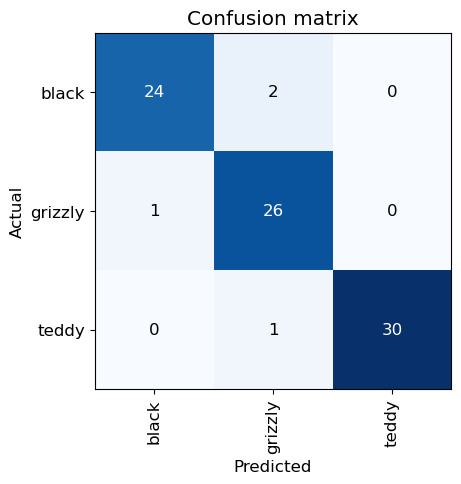

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

It's helpful to see where exactly the errors are occurring, to see whether they're due to a dataset problem (e.g., images that aren't bears at all, or are labeled incorrectly, etc.) or a model problem (perhaps it isn't handling images taken with unusual lighting, or from a different angle, etc.). To do this, images can be sorted by their _loss_.

The _loss_ is a number that is higher if the model is incorrect, or if it's correct, but not confident of its correct answer

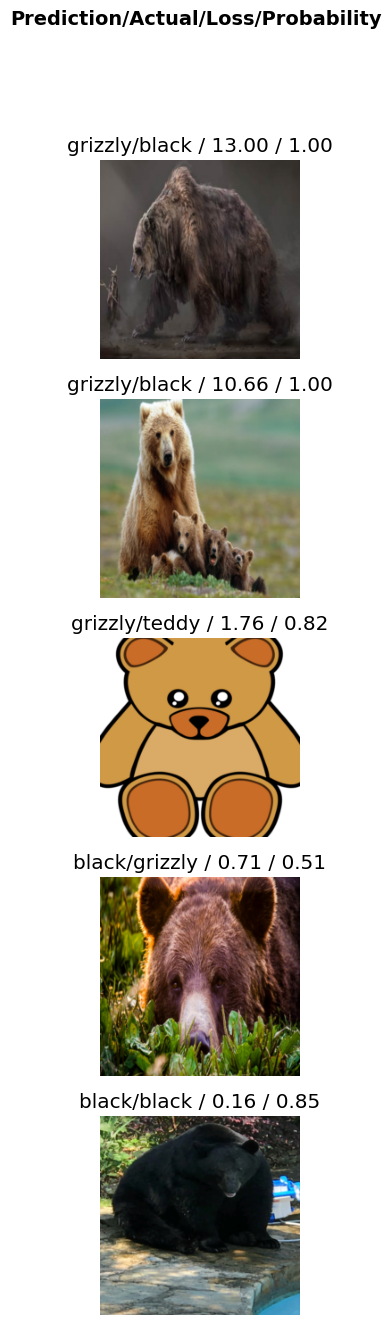

In [24]:
interp.plot_top_losses(5, nrows=5)

We can see that we have some mislabeled data and this needs to be fixed. Data cleansing is typically done before we train the model, however you can also train a quick and simple model first and then use it to help with data cleaning.

`fastai` includes a handy GUI for data cleaning called `ImageClassifierCleaner` that allows you to choose a category and the training versus validation set and view the highest-loss iamges (in order), along with menus to allow images to be selected for removal or relabeling:

In [30]:
cleaner = ImageClassifierCleaner(learn)
cleaner

FileNotFoundError: [Errno 2] No such file or directory: '/Users/charlie/github.com/charlieroth/fastai/Lesson 02/bears/black/d4aaa47f-b82f-4a28-8601-69ff16032f00.jpg'

In [29]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

FileNotFoundError: [Errno 2] No such file or directory: 'bears/black/d9e5caf2-e715-46ad-a14e-c3f2a815c0e9.jpg'

In [28]:
for idx, category in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/category)

Error: Destination path 'bears/black/6a8ffce3-9061-45df-ba1d-7e54f831e2d8.jpg' already exists